In [1]:
#Grab historical Sales data
#Seasonality Variables, Qtr, Period
#Event sku?
# Sku age
# CPI
%matplotlib inline

In [2]:
print(str(60000*60*365))

1314000000


In [3]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")

import HelperPI
import seaborn as sbs
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt

In [4]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [11]:
sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\InventoryForecasting.sql")

In [12]:
base, dtypesdf = helper.readData(sql)

INFO:root:Reading data...
INFO:root:Data read complete...


                 Count Column Type
0           DATE_VALUE      object
1              UMCSENT     float64
2         STORE_NUMBER      object
3   SKU_DISPLAY_NUMBER      object
4                   Q1       int64
5                   Q2       int64
6                   Q3       int64
7                   Q4       int64
8                   P1       int64
9                   P2       int64
10                  P3       int64
11                  P4       int64
12                  P5       int64
13                  P6       int64
14                  P7       int64
15                  P8       int64
16                  P9       int64
17                 P10       int64
18                 P11       int64
19                 P12       int64
20                  D1       int64
21                  D2       int64
22                  D3       int64
23                  D4       int64
24                  D5       int64
25                  D6       int64
26                  D7       int64
27             SKU_A

In [13]:
base.head()

,DATE_VALUE,UMCSENT,STORE_NUMBER,SKU_DISPLAY_NUMBER,Q1,Q2,Q3,Q4,P1,P2,...,D1,D2,D3,D4,D5,D6,D7,SKU_AGE,EVENT_SKU,TARGET_UNITS
0,2015-01-04,98.1,001,389648,1,0,0,0,1,0,...,1,0,0,0,0,0,0,8274,0,2.0
1,2015-01-05,98.1,001,389648,1,0,0,0,1,0,...,0,1,0,0,0,0,0,8274,1,1.0
2,2015-01-06,98.1,001,389648,1,0,0,0,1,0,...,0,0,1,0,0,0,0,8274,1,2.0
3,2015-01-07,98.1,001,389648,1,0,0,0,1,0,...,0,0,0,1,0,0,0,8274,1,1.0
4,2015-01-10,98.1,001,389648,1,0,0,0,1,0,...,0,0,0,0,0,0,1,8274,1,3.0


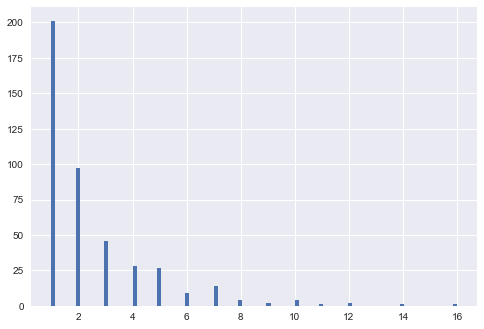

In [14]:
plt.hist('TARGET_UNITS', bins=100, data=base);

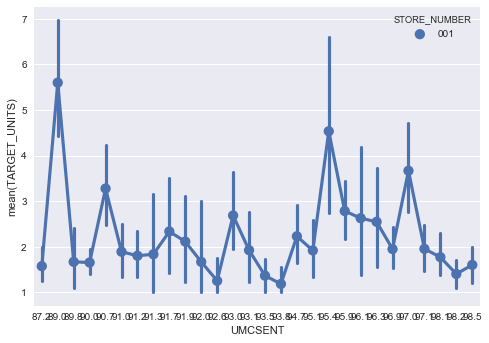

In [15]:
sbs.pointplot(x='UMCSENT', y='TARGET_UNITS', hue='STORE_NUMBER', data=base);